In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from pathlib import Path
import argparse
import math
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc

sys.path.insert(0, '..')

from util.xai import gradcam, interpolate_expl_matrix, plot_matrix
from models.nt_classifier import build as build_model
from config import *
from util.plot_utils import obtain_plot, plot_logs, plot_roc_curves, collect_results_based_on_confidence_level
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!

<class 'transformers.tokenization_dna.DNATokenizer'>


In [20]:
checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints', 'binary_cl2_13e23') #binary_cl2_old_best, binary_cl2_4

In [21]:
# Define the path to the file containing the args namespace
args_path = os.path.join(checkpoint_dir, 'args.pkl')

# Load the args namespace from the file
with open(args_path, 'rb') as f:
    args_dict = pickle.load(f)
    
print(args_dict)

{'lr': 0.0001, 'lr_backbone': 0.0001, 'batch_size': 32, 'weight_decay': 0.0001, 'epochs': 100, 'lr_drop': 200, 'clip_max_norm': 0.1, 'proj_module_N_channels': 0, 'proj_module_secondary_structure_N_channels': 4, 'drop_secondary_structure': False, 'use_projection_module': False, 'dropout_prob': 0.01, 'args.mini_batch_size': 32, 'num_hidden_layers': 1, 'dividing_factor': 20, 'output_channels_mlp': 256, 'n_channels1_cnn': 400, 'n_channels2_cnn': 600, 'min_n_groups_train': 5, 'max_n_groups_train': 80, 'min_n_groups_val': 80, 'max_n_groups_val': 80, 'policies_train': [<dataset.data.EasyPosAugment object at 0x7f280c6136d0>, <dataset.data.SmartNegAugment object at 0x7f280c613940>], 'policies_val': [<dataset.data.EasyPosAugment object at 0x7f280c606c10>, <dataset.data.SmartNegAugment object at 0x7f280c606310>], 'dataset_path': '/data01/giorgio/RNARNA-NT/dataset', 'device': 'cuda', 'seed': 42, 'num_workers': 2, 'output_dir': '/data01/giorgio/RNARNA-NT/checkpoints/binary_cl2', 'resume': '', 'star

In [5]:
#args_dict['policies_train'][0].height_probabilities

In [6]:
#args_dict['policies_train'][0].height_bins

In [7]:
file_train = os.path.join(rna_rna_files_dir, "gene_pairs_training_nt.txt")
with open(file_train, "rb") as fp:   # Unpickling
    gene_pairs_train = pickle.load(fp)
    
file_test = os.path.join(rna_rna_files_dir, "gene_pairs_test_nt.txt")
with open(file_test, "rb") as fp:   # Unpickling
    gene_pairs_test = pickle.load(fp)
    
file_test_subset = os.path.join(rna_rna_files_dir, "gene_pairs_test_sampled_nt.txt")
with open(file_test_subset, "rb") as fp:   # Unpickling
    gene_pairs_test_subset = pickle.load(fp)

In [8]:
test500 = pd.read_csv(os.path.join(metadata_dir, 'test500.csv'))

In [9]:
assert test500.couples.isin(gene_pairs_test).all()

In [10]:
res = pd.read_csv(os.path.join(checkpoint_dir, 'test_results500.csv'))

print(classification_report(res.ground_truth, res.prediction))

FileNotFoundError: [Errno 2] No such file or directory: '/data01/giorgio/RNARNA-NT/checkpoints/binary_cl2_10e18/test_results500.csv'

In [ ]:
test500['seed_w'] = test500['seed_x2'] - test500['seed_x1']
test500['seed_h'] = test500['seed_y2'] - test500['seed_y1']

res = res.merge(test500[['couples', 'seed_w', 'seed_h']].rename({'couples':'id_sample'}, axis = 1), on = 'id_sample')

In [ ]:
intarna = pd.read_csv(os.path.join(intarna_dir, 'test500', 'test.csv'), sep = ';')
intarna['key'] = intarna.id1 + '_' + intarna.id2

# keep only the lower E_norm for each group
intarna.sort_values('E_norm', ascending = False, inplace=True)
intarna.drop_duplicates(subset='key', keep='first', inplace=True)
intarna = intarna.reset_index(drop = True)
intarna['couples'] = intarna.id1.str.extractall('(.*)_(.*)').reset_index(drop = True)[0]
intarna['couples'] = intarna['couples'].astype(int)

res = res.merge(intarna[['E','E_norm', 'couples']].rename({'couples':'id_sample'}, axis =1), on = 'id_sample')

# PLOTS

## Metrics

In [ ]:
def obtain_acc_and_perc(treshold, res, test500):
    original_res_shape = res.shape[0]
    #take only big windows
    subset = test500[ (abs(test500.seed_x1 - test500.seed_x2) >treshold) & (abs(test500.seed_y1 - test500.seed_y2) > treshold) ]
    res = res[res.id_sample.isin(subset.couples)]
    
    perc = np.round((res.shape[0] / original_res_shape)*100, 2)
    
    res = balance_df(res)

    acc = (res.prediction == res.ground_truth).sum()/res.shape[0]
    return acc, perc

def balance_df(df, n_iter = 25):
    toappend = []
    if df[df.ground_truth == 0].shape[0] > df[df.ground_truth == 1].shape[0]:
        for i in range(n_iter):
            negs = df[df.ground_truth == 0]
            poss = df[df.ground_truth == 1]
            toappend.append(pd.concat([negs.sample(len(poss)), poss], axis = 0))
    else:
        for i in range(n_iter):
            negs = df[df.ground_truth == 0]
            poss = df[df.ground_truth == 1]
            toappend.append(pd.concat([poss.sample(len(negs)), negs], axis = 0))
    balanced = pd.concat(toappend, axis = 0)
    return balanced

In [ ]:
n_conf = 10

In [ ]:
test = pd.read_csv(os.path.join(metadata_dir, f'test_sampled.csv'))
print(test.interacting.value_counts())
test = test[['id_gene1_sample', 'id_gene2_sample']]

In [11]:
res1 = res.merge(test, left_on = ['g1', 'g2'], right_on = ['id_gene1_sample', 'id_gene2_sample'])
res2 = res.merge(test, left_on = ['g1', 'g2'], right_on = ['id_gene2_sample', 'id_gene1_sample'])
easypos_smartneg = pd.concat([res1, res2], axis = 0)
easypos_smartneg.ground_truth.value_counts()

NameError: name 'res' is not defined

0.5733054335894622


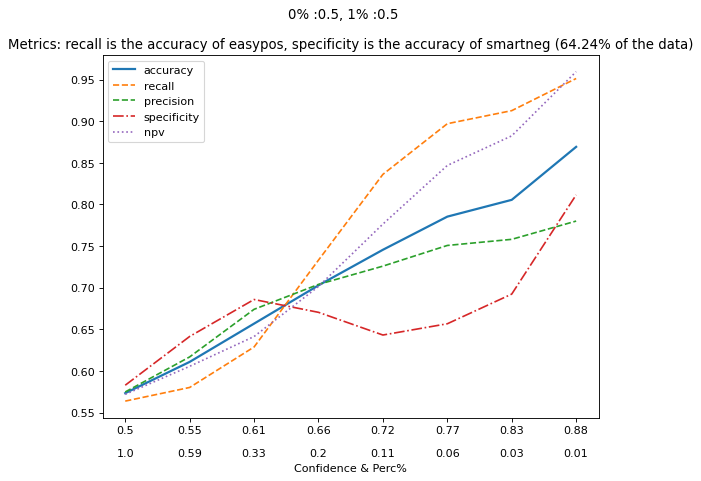

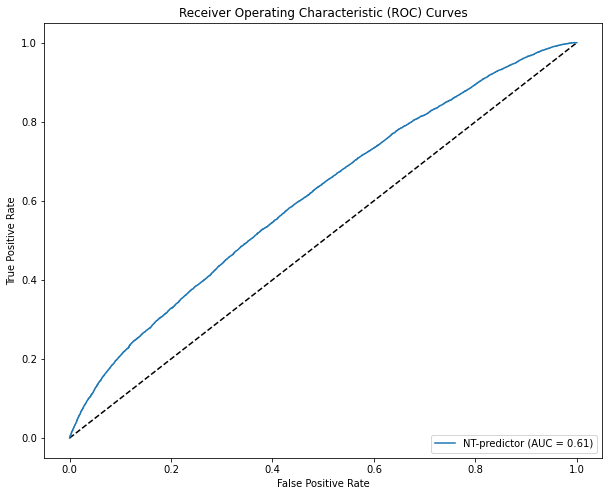

In [17]:
easypos_smartneg_sampled = easypos_smartneg
print((easypos_smartneg_sampled.prediction == easypos_smartneg_sampled.ground_truth).sum()/easypos_smartneg_sampled.shape[0])
obtain_plot(easypos_smartneg_sampled, n_original_df = res.shape[0], title = f'Metrics: recall is the accuracy of easypos, specificity is the accuracy of smartneg ', n_conf = n_conf)
plot_roc_curves([{'prob': easypos_smartneg_sampled.probability, 'model_name': 'NT-predictor'}], easypos_smartneg_sampled.ground_truth)

0.614526588845655


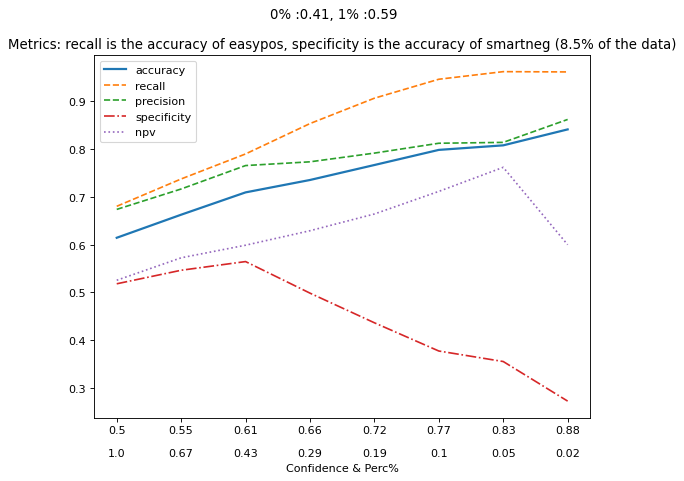

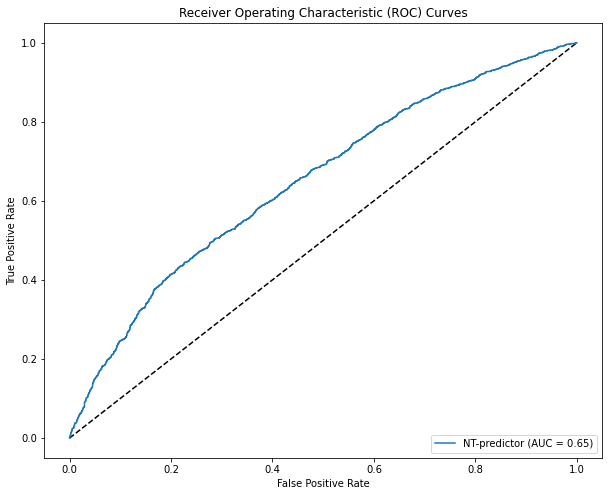

In [33]:
treshold = 25

subset = easypos_smartneg_sampled[(easypos_smartneg_sampled.seed_w > treshold) & (easypos_smartneg_sampled.seed_h > treshold)]
#subset = balance_df(subset)
print((subset.prediction == subset.ground_truth).sum()/subset.shape[0])
obtain_plot(subset, n_original_df = res.shape[0], title = f'Metrics: recall is the accuracy of easypos, specificity is the accuracy of smartneg ', n_conf = n_conf)
plot_roc_curves([{'prob': subset.probability, 'model_name': 'NT-predictor'}], subset.ground_truth)

Text(0, 0.5, 'Accuracy SmartNeg VS EasyPos')

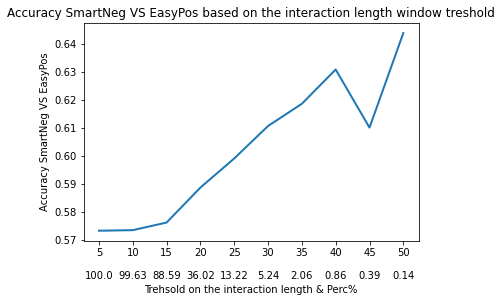

In [34]:
tresholds = np.linspace(5, 50, 10).astype(int)
accuracies = []
percs = []
for treshold in tresholds:
    acc, perc = obtain_acc_and_perc(treshold, easypos_smartneg_sampled, test500)
    accuracies.append(acc)
    percs.append(perc)

merged_x_axis = []
for i in range(0, len(percs)):
    tuple_to_print = (np.round(tresholds[i],2), np.round(percs[i], 2))
    merged_x_axis.append('\n\n'.join(str(x) for x in tuple_to_print))

plt.title('Accuracy SmartNeg VS EasyPos based on the interaction length window treshold')

plt.plot(merged_x_axis, accuracies, label = 'accuracy', linewidth=2)

plt.xlabel(f"Trehsold on the interaction length & Perc%")
plt.ylabel(f"Accuracy SmartNeg VS EasyPos")

Text(0, 0.5, 'Accuracy SmartNeg VS EasyPos, Not in training')

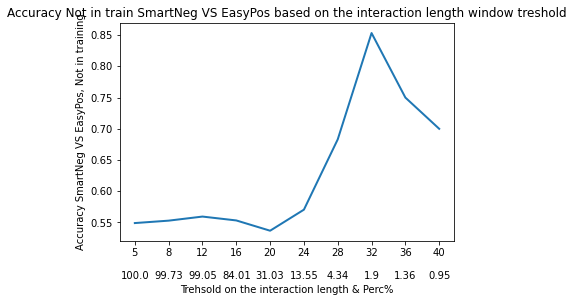

In [35]:
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
regex = df_nt[df_nt.couples.isin(gene_pairs_train)].couples_id.str.extractall('(.*)_(.*)').reset_index()
df_train = regex
df_train['g1'] = regex[0]
df_train['g2'] = regex[1]
df_train_genes = set(df_train['g1']).union(set(df_train['g2']))

not_in_train = res[~(res.gene1_original.isin(df_train_genes) | res.gene2_original.isin(df_train_genes))]


not_in_train_epsn = not_in_train[(not_in_train.policy == 'easypos')|(not_in_train.policy == 'smartneg')]



tresholds = np.linspace(5, 40, 10).astype(int)
accuracies = []
percs = []
for treshold in tresholds:
    acc, perc = obtain_acc_and_perc(treshold, not_in_train_epsn, test500)
    accuracies.append(acc)
    percs.append(perc)

merged_x_axis = []
for i in range(0, len(percs)):
    tuple_to_print = (np.round(tresholds[i],2), np.round(percs[i], 2))
    merged_x_axis.append('\n\n'.join(str(x) for x in tuple_to_print))

plt.title('Accuracy Not in train SmartNeg VS EasyPos based on the interaction length window treshold')

plt.plot(merged_x_axis, accuracies, label = 'accuracy', linewidth=2)

plt.xlabel(f"Trehsold on the interaction length & Perc%")
plt.ylabel(f"Accuracy SmartNeg VS EasyPos, Not in training")

/tmp/ipykernel_34082/2968121538.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['confidence'] = abs(0.5-data.probability) + 0.5
/tmp/ipykernel_34082/2968121538.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['seed_area'] = data.seed_w * data.seed_h #( (data.seed_w > treshold) &  (data.seed_h > treshold) ).astype(int)


Correlation: 0.20673558156648245


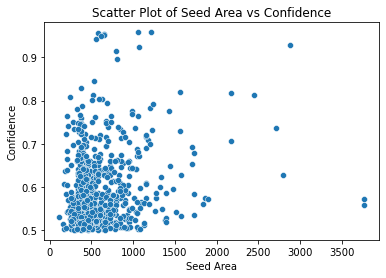

In [36]:
data = not_in_train_epsn
data['confidence'] = abs(0.5-data.probability) + 0.5
data['seed_area'] = data.seed_w * data.seed_h #( (data.seed_w > treshold) &  (data.seed_h > treshold) ).astype(int)

# Assuming you have the data loaded in 'data' DataFrame
correlation = data.seed_area.corr(data.confidence)

print("Correlation:", correlation)

sns.scatterplot(x='seed_area', y='confidence', data=data)
plt.xlabel('Seed Area')
plt.ylabel('Confidence')
plt.title('Scatter Plot of Seed Area vs Confidence')
plt.show()

0.6086666666666667


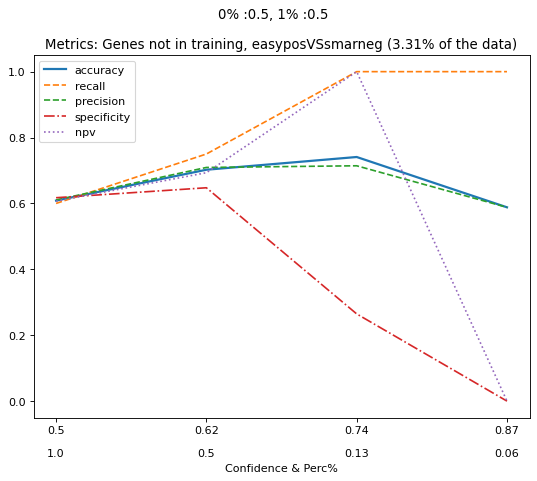

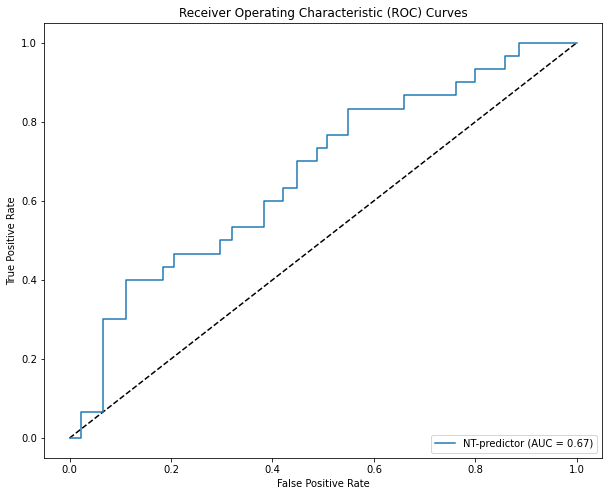

In [37]:
treshold = 25

subset = not_in_train_epsn[(not_in_train_epsn.seed_w > treshold) & (not_in_train_epsn.seed_h > treshold)]
subset = balance_df(subset)
print((subset.prediction == subset.ground_truth).sum()/subset.shape[0])
obtain_plot(subset, n_original_df = res.shape[0], title = f'Metrics: Genes not in training, easyposVSsmarneg ', n_conf = 5)
plot_roc_curves([{'prob': subset.probability, 'model_name': 'NT-predictor'}], subset.ground_truth)

# Compare with INTARNA

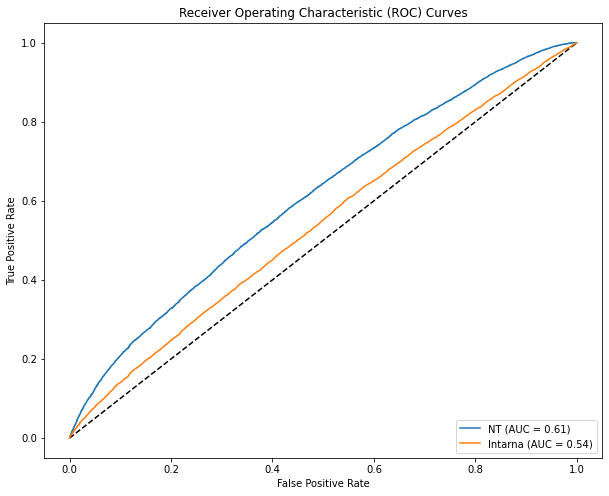

In [38]:
plot_roc_curves([{'prob': easypos_smartneg_sampled.probability, 'model_name': 'NT'},
                 {'prob': abs(easypos_smartneg_sampled.E_norm), 'model_name': 'Intarna'}
                ], easypos_smartneg_sampled.ground_truth)

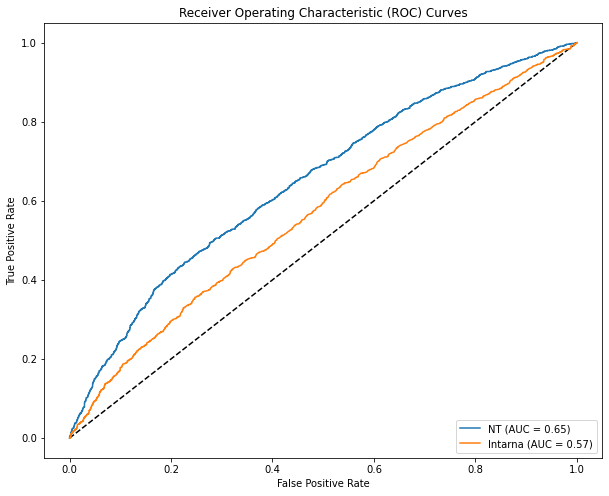

In [39]:
treshold = 25

subset = easypos_smartneg_sampled[(easypos_smartneg_sampled.seed_w > treshold) & (easypos_smartneg_sampled.seed_h > treshold)]
plot_roc_curves([{'prob': subset.probability, 'model_name': 'NT'},
                 {'prob': abs(subset.E_norm), 'model_name': 'Intarna'}
                ], subset.ground_truth)

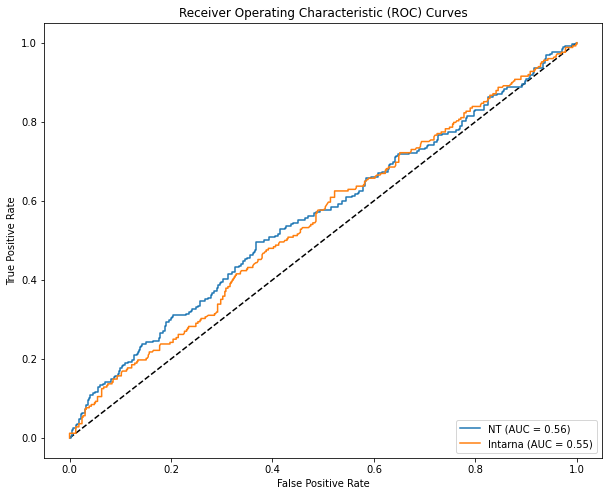

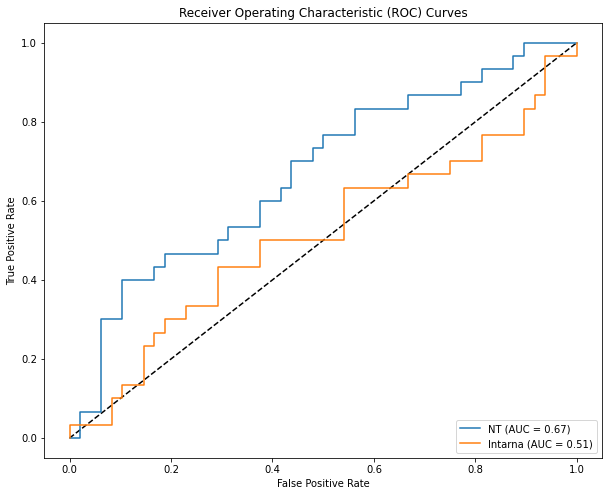

In [40]:
plot_roc_curves([{'prob': not_in_train_epsn.probability, 'model_name': 'NT'},
                 {'prob': abs(not_in_train_epsn.E_norm), 'model_name': 'Intarna'}
                ], not_in_train_epsn.ground_truth)


treshold = 25

subset = not_in_train_epsn[(not_in_train_epsn.seed_w > treshold) & (not_in_train_epsn.seed_h > treshold)]
plot_roc_curves([{'prob': subset.probability, 'model_name': 'NT'},
                 {'prob': abs(subset.E_norm), 'model_name': 'Intarna'}
                ], subset.ground_truth)

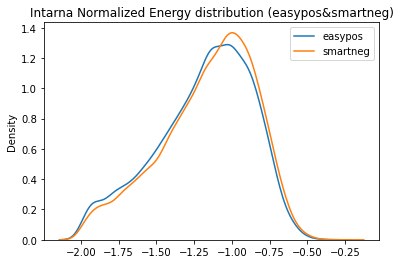

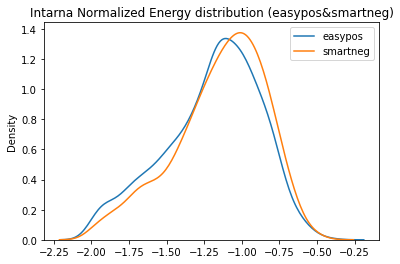

In [41]:
treshold_plot = -2
sns.kdeplot(list(easypos_smartneg_sampled[(easypos_smartneg_sampled.policy == 'easypos')&(easypos_smartneg_sampled.E_norm>treshold_plot)].E_norm), label = 'easypos')
sns.kdeplot(list(easypos_smartneg_sampled[(easypos_smartneg_sampled.policy == 'smartneg')&(easypos_smartneg_sampled.E_norm>treshold_plot)].E_norm), label = 'smartneg')
plt.title(f'Intarna Normalized Energy distribution (easypos&smartneg)')
plt.legend()
plt.show()

subset = easypos_smartneg_sampled[(easypos_smartneg_sampled.seed_w > treshold) & (easypos_smartneg_sampled.seed_h > treshold)]
treshold_plot = -2
sns.kdeplot(list(subset[(subset.policy == 'easypos')&(subset.E_norm>treshold_plot)].E_norm), label = 'easypos')
sns.kdeplot(list(subset[(subset.policy == 'smartneg')&(subset.E_norm>treshold_plot)].E_norm), label = 'smartneg')
plt.title(f'Intarna Normalized Energy distribution (easypos&smartneg)')
plt.legend()
plt.show()

# XAI

In [42]:
df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt.csv'))

DEVICE = 'cpu'

args_path = os.path.join(checkpoint_dir, 'args.pkl')

# Load the args namespace from the file
with open(args_path, 'rb') as f:
    args_dict = pickle.load(f)

# Convert the dictionary to an argparse.Namespace object
args = argparse.Namespace(**args_dict)
args.resume = os.path.join(checkpoint_dir, 'best_model.pth') # best_model

device = torch.device(DEVICE)
model = build_model(args)

checkpoint = torch.load(args.resume, map_location='cpu')
model.load_state_dict(checkpoint['model'])

model.to(device)
model.eval()

/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


BinaryClassifierNT(
  (nt_projection_module): NTProjectionModule(
    (conv1d): Conv1d(2560, 0, kernel_size=(1,), stride=(1,))
    (bn): BatchNorm1d(2560, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (top_classifier): MLP(
    (input_layer): Sequential(
      (0): LayerNorm((5120,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=5120, out_features=256, bias=True)
    )
    (hidden_layers): ModuleList(
      (0): Linear(in_features=256, out_features=256, bias=True)
    )
    (output_layer): Linear(in_features=256, out_features=256, bias=True)
    (activation_functions): ModuleList(
      (0): Tanh()
      (1): ReLU()
    )
    (dropout_layers): ModuleList(
      (0): Dropout(p=0.01, inplace=False)
      (1): Dropout(p=0.01, inplace=False)
    )
  )
  (small_cnn): SmallCNN(
    (conv1): Conv2d(256, 400, kernel_size=(2, 2), stride=(1, 1))
    (conv2): Conv2d(400, 600, kernel_size=(1, 1), stride=(1, 1))
    (relu): ReLU()
    (maxpool2d): MaxPool

In [67]:
xai = pd.read_csv(os.path.join(checkpoint_dir, 'gradcam_results500.csv'))

In [69]:
xai = xai.merge(res.filter([
   'seed_w', 'seed_h', 'couples', 'gene1_pc', 'gene2_pc', 'original_length1', 'original_length2', 'id_sample', 'g1', 'g2', 'gene1_original', 'gene2_original'
], axis = 1), left_on = 'id', right_on = 'id_sample')

In [70]:
gradcam_results = xai[xai.probability>0.5]

iou_value: 0.0058
iou_value_tr: 0.0049
iou_value_rand: 0.0028


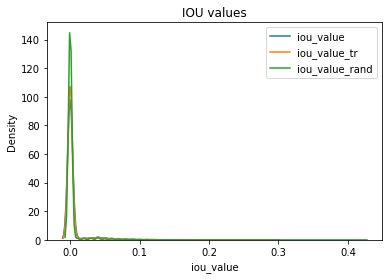

intensity: 0.4605
intensity_tr: 0.1567
intensity_rand: 0.5


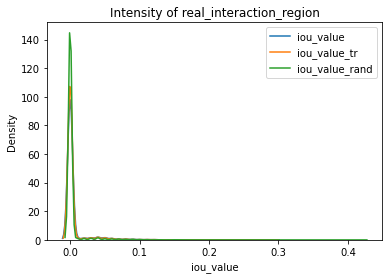

euclidean: 0.4756
euclidean_rand: 0.5323
euclidean_bbox_tr: 0.4941


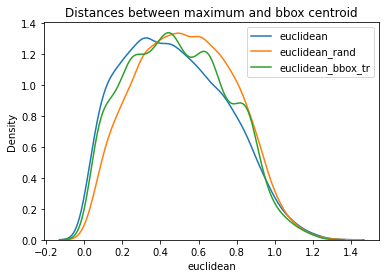

cos_sim: 0.05
cos_sim_tr: 0.04
cos_sim_rand: 0.04


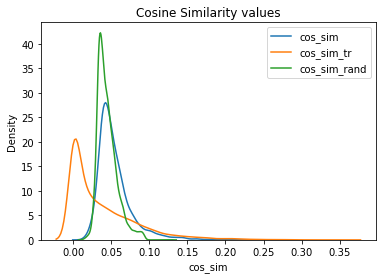

In [71]:
iou_columns = ['iou_value', 'iou_value_tr', 'iou_value_rand']
for c in iou_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in iou_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'IOU values')
plt.legend()
plt.show()

intensity_columns = ['intensity', 'intensity_tr', 'intensity_rand']
for c in intensity_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in iou_columns:
    sns.kdeplot(gradcam_results[c], label = c)
    
plt.title(f'Intensity of real_interaction_region')
plt.legend()
plt.show()

euclidean_columns = ['euclidean', 'euclidean_rand', 'euclidean_bbox_tr']
for c in euclidean_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in euclidean_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Distances between maximum and bbox centroid')
plt.legend()
plt.show()

cosine_sim_columns = ['cos_sim', 'cos_sim_tr', 'cos_sim_rand']
for c in cosine_sim_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 2))}')

for c in cosine_sim_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Cosine Similarity values')
plt.legend()
plt.show()

#### Subset XAI results

In [72]:
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
regex = df_nt[df_nt.couples.isin(gene_pairs_train)].couples_id.str.extractall('(.*)_(.*)').reset_index()
df_train = regex
df_train['g1'] = regex[0]
df_train['g2'] = regex[1]
df_train_genes = set(df_train['g1']).union(set(df_train['g2']))

euclidean: 0.4492
euclidean_rand: 0.5498


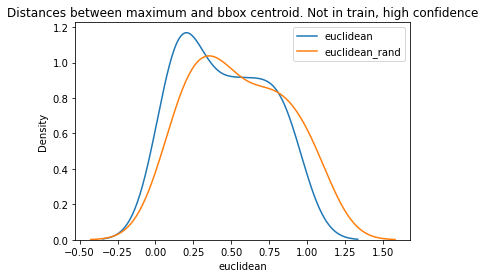

In [73]:
gradcam_results = xai[~(xai.gene1_original.isin(df_train_genes) | xai.gene2_original.isin(df_train_genes))]
gradcam_results = gradcam_results[(gradcam_results.probability>0.65)&(gradcam_results.probability<0.8)]

euclidean_columns = ['euclidean', 'euclidean_rand']
for c in euclidean_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in euclidean_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Distances between maximum and bbox centroid. Not in train, high confidence')
plt.legend()
plt.show()

euclidean: 0.4493
euclidean_rand: 0.5232


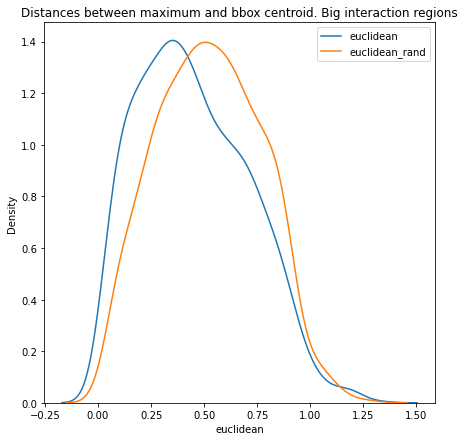

In [97]:
treshold = 25
gradcam_results = xai[(xai.seed_w>treshold)&(xai.seed_h>treshold)]
gradcam_results = gradcam_results[(gradcam_results.probability>0.5)]

euclidean_columns = ['euclidean', 'euclidean_rand']
for c in euclidean_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in euclidean_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Distances between maximum and bbox centroid. Big interaction regions')
plt.legend()
plt.show()

In [98]:
def plot_query_results(query):
    for _, row in query.iterrows():
        x1_emb, x2_emb, y1_emb, y2_emb = int(np.round(row.x1/6)), int(np.round(row.x2/6)), int(np.round(row.y1/6)), int(np.round(row.y2/6))
        
        embedding1_path = os.path.join(embedding_dir, '32', row.gene1+'.npy')
        embedding2_path = os.path.join(embedding_dir, '32', row.gene2+'.npy')

        embedding1 = np.load(embedding1_path)[x1_emb:x2_emb :]
        embedding2 = np.load(embedding2_path)[y1_emb:y2_emb, :]

        rna1, rna2 = torch.as_tensor(embedding1).unsqueeze(0), torch.as_tensor(embedding2).unsqueeze(0)
        rna1, rna2 = torch.transpose(rna1, 1, 2), torch.transpose(rna2, 1, 2)

        rna1, rna2 = rna1.to(device), rna2.to(device)
        
        outputs = model(rna1, rna2)

        outputs[:, 1].backward()
        #print('prob:', outputs.softmax(-1)[:, 1])
        #print('degree:', row.abs_sum_diff)
        x1 = int(row.seed_x1-row.x1)
        x2 = int(row.seed_x2-row.x1)
        y1 = int(row.seed_y1-row.y1)
        y2 = int(row.seed_y2-row.y1)
        width = row.len1
        height = row.len2
        

        expl_matrix = gradcam(model, rna1, rna2, counterfactual = False, cnn_layer = 2)
        
        expl_matrix_reshaped = interpolate_expl_matrix(expl_matrix, height=height, width=width)
        
        # print(x1, x2, y1, y2)
        # print(expl_matrix_reshaped.shape)

        scaling_factor = 70

        plot_matrix(expl_matrix_reshaped, 
        [[y1, x1, y2-y1, x2-x1]], #crop_bbox =[x1hat, y1hat, what, hhat], 
        cmap ='viridis', 
        scaling_factor = scaling_factor)
        plt.show()

euclidean: 0.5412
euclidean_rand: 0.5448


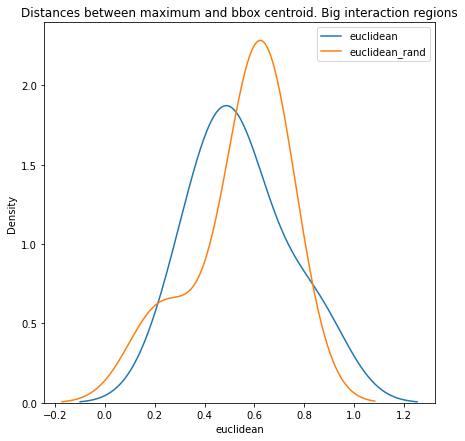

In [99]:
treshold = 30
gradcam_results = xai[~(xai.gene1_original.isin(df_train_genes) | xai.gene2_original.isin(df_train_genes))]
gradcam_results = gradcam_results[(gradcam_results.seed_w>treshold)&(gradcam_results.seed_h>treshold)]
gradcam_results = gradcam_results[(gradcam_results.probability>0.5)]

euclidean_columns = ['euclidean', 'euclidean_rand']
for c in euclidean_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in euclidean_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Distances between maximum and bbox centroid. Big interaction regions')
plt.legend()
plt.show()

Not in training, big interaction window

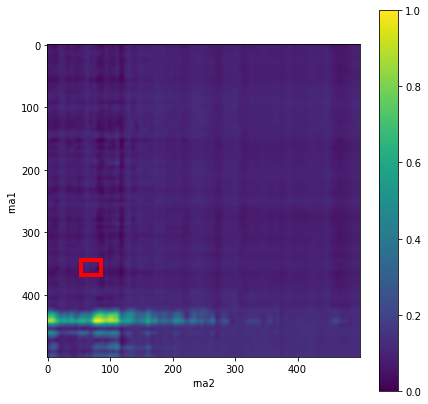

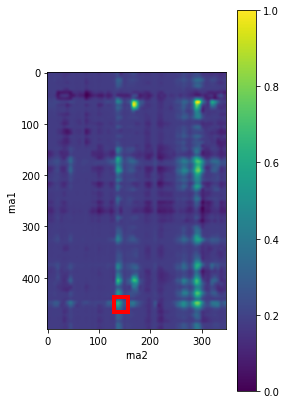

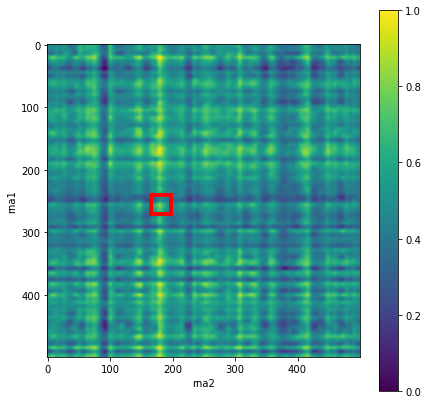

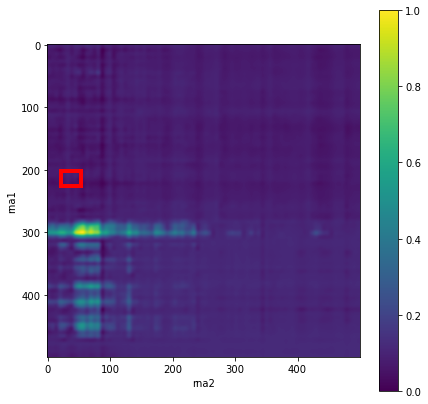

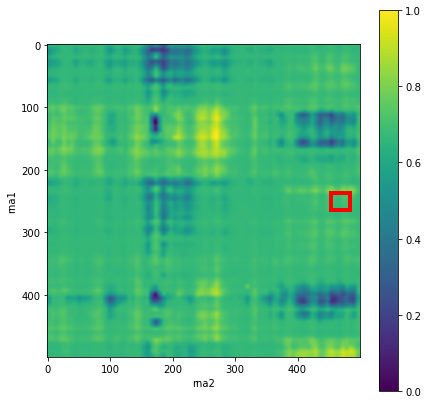

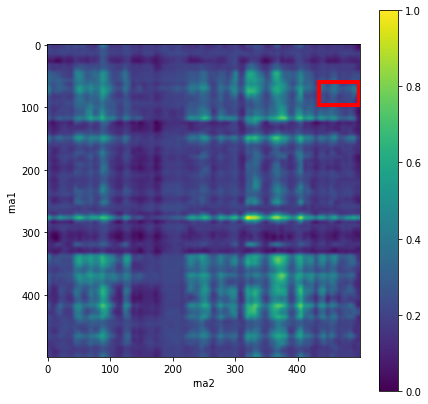

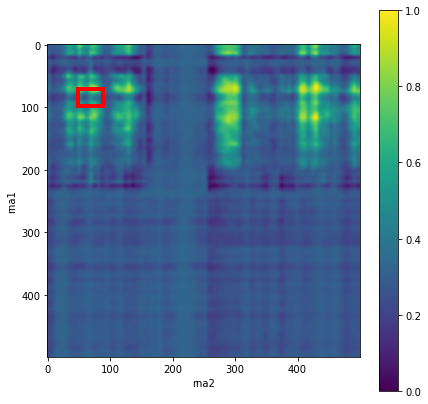

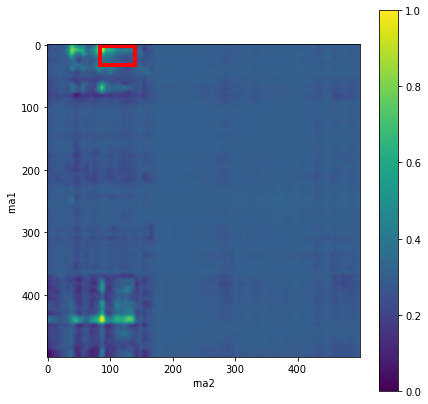

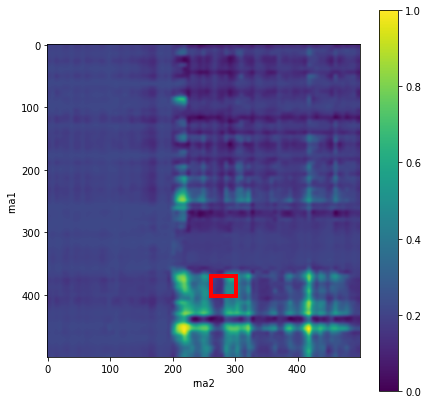

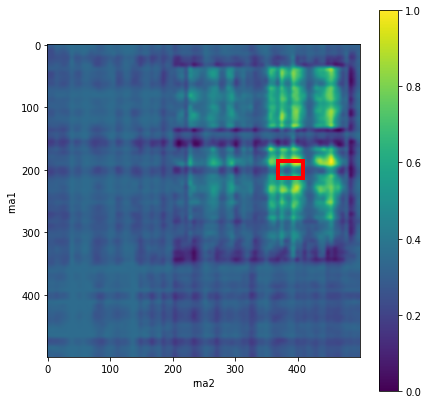

In [101]:
plot_query_results(query.sample(10))